In [4]:
import pandas as pd
import numpy as np
from datetime import datetime
import sweetviz as sv
from nltk import ngrams
from nltk.corpus import stopwords
from wordcloud import WordCloud
from gensim import corpora, models
from leia import SentimentIntensityAnalyzer
import collections
import re
import matplotlib.pyplot as plt

## 1. Lendo e tratando a base de dados

In [5]:
with open('churn_com_texto.csv', encoding='utf-8') as f:
    rawText = f.read()

In [6]:
rawText = rawText.split('\n')

In [7]:
#Corrigindo virgulas adicionais dentro dos comentários
fixedComma = [rawText[0]]
for line in rawText[1:]:
    pieces = line.split('"')
    if len(pieces) == 2:
        fixedLine = pieces[0] + pieces[1].replace(',', ' ') + '"'
    else:
        fixedLine = pieces[0] + pieces[1].replace(',', ' ') + pieces[2]
    fixedComma.append(fixedLine)

In [8]:
#Corrigindo formato das linhas
fixedText = []
for line in fixedComma:
    if line.count(',') == 13:
        first, second = line.split(',')[:11], line.split(',')[12:]
        first.append(',')
        first.extend(second)
        fixedText.append(','.join(first))
    else:
        fixedText.append(line)

In [9]:
dataChurn = pd.DataFrame([line.split(',') for line in fixedText[1:]],
                         columns=fixedText[0].split(','))

In [10]:
dataChurn.describe()

,ID,Nome,Idade,Gênero,Localização,Estado Civil,Número de Dependentes,Data de Início do Contrato,Data de Término do Contrato,Valor Mensal do Contrato,Tipo de Serviço,Duração Média das Chamadas,Volume de Dados,Número de Reclamações,Comentários
count,102,102,102,102,102,102,102,102,102,102,102,102,102,102,102
unique,101,89,22,2,6,4,4,56,5,12,4,20,9,5,93
top,1068,Carolina Oliveira,29,Feminino,São Paulo/SP/São Paulo,Casado,0,2022-09-01,,99.99,Internet,,,0,Estou satisfeita com o serviço de telefonia mó...
freq,2,3,11,52,29,53,47,10,98,21,31,73,48,37,3


## 2. Tratamento de colunas

In [11]:
dataChurn

,ID,Nome,Idade,Gênero,Localização,Estado Civil,Número de Dependentes,Data de Início do Contrato,Data de Término do Contrato,Valor Mensal do Contrato,Tipo de Serviço,Duração Média das Chamadas,Volume de Dados,Número de Reclamações,Comentários
0,1,João Silva,35,Masculino,São Paulo/SP/São Paulo,Casado,2,2018-05-10,,79.99,Telefonia Móvel,4.5,2.3 GB,2,O serviço de internet tem sido instável. Estou...
1,2,Maria Santos,28,Feminino,Rio de Janeiro/RJ/Rio de Janeiro,Solteiro,0,2019-03-15,,109.99,Internet,,-,0,Estou satisfeita com o serviço. A velocidade d...
2,3,Carlos Oliveira,42,Masculino,Belo Horizonte/MG/Minas Gerais,Casado,1,2020-01-20,2021-06-30,139.99,Internet,,-,1,Tive problemas com a fatura deste mês. O valor...
3,4,Ana Pereira,55,Feminino,Porto Alegre/RS/Rio Grande do Sul,Viúvo,0,2017-09-01,,159.99,Telefonia Fixa,6.2,,-,Sem reclamações até o momento. O serviço tem a...
4,5,Paulo Rodrigues,41,Masculino,Brasília/DF,Divorciado,3,2019-11-12,2022-01-05,99.99,TV a Cabo,,-,0,O canal de esportes não está funcionando corre...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,1098,Patrícia Lima,26,Feminino,Porto Alegre/RS/Rio Grande do Sul,Solteiro,0,2023-01-15,,89.99,Telefonia Móvel,,,Extremamente Negativo,Estou extremamente desapontada com o serviço d...
98,1099,André Silva,39,Masculino,Rio de Janeiro/RJ/Rio de Janeiro,Casado,2,2020-05-01,,149.99,Internet,,,Extremamente Negativo,A internet dessa empresa é um verdadeiro pesad...
99,1100,Amanda Almeida,27,Feminino,São Paulo/SP/São Paulo,Casado,1,2018-12-10,,109.99,TV a Cabo,,,Extremamente Negativo,O serviço de TV a cabo dessa empresa é uma dec...
100,1101,Rodrigo Santos,33,Masculino,Belo Horizonte/MG/Minas Gerais,Solteiro,0,2022-09-01,,99.99,Telefonia Fixa,,,Extremamente Negativo,A telefonia fixa dessa empresa é uma vergonha....


Feature: ID                                  |▋         | [  6%]   00:00 -> (00:00 left)c:\Users\jpfas\Downloads\CaseA3\.venv\lib\site-packages\sweetviz\from_profiling_pandas.py:65: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(keys):
Feature: Nome                                |█▎        | [ 12%]   00:00 -> (00:00 left)c:\Users\jpfas\Downloads\CaseA3\.venv\lib\site-packages\sweetviz\from_profiling_pandas.py:65: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(keys):
Feature: Idade                               |█▉        | [ 19%]   00:00 -> (00:00 left)c:\Users\jpfas\Downloads\CaseA3\.venv\lib\site-packages\sweetviz\from_profiling_pandas.py:65: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future ve


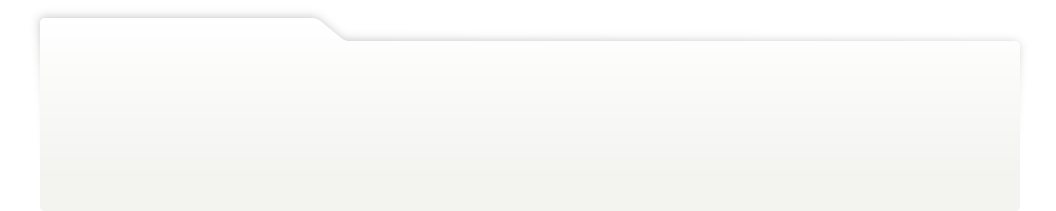
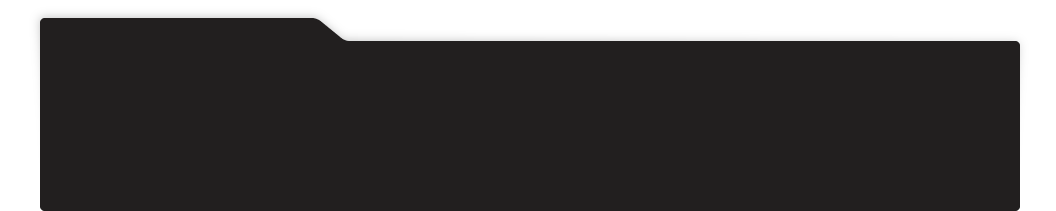
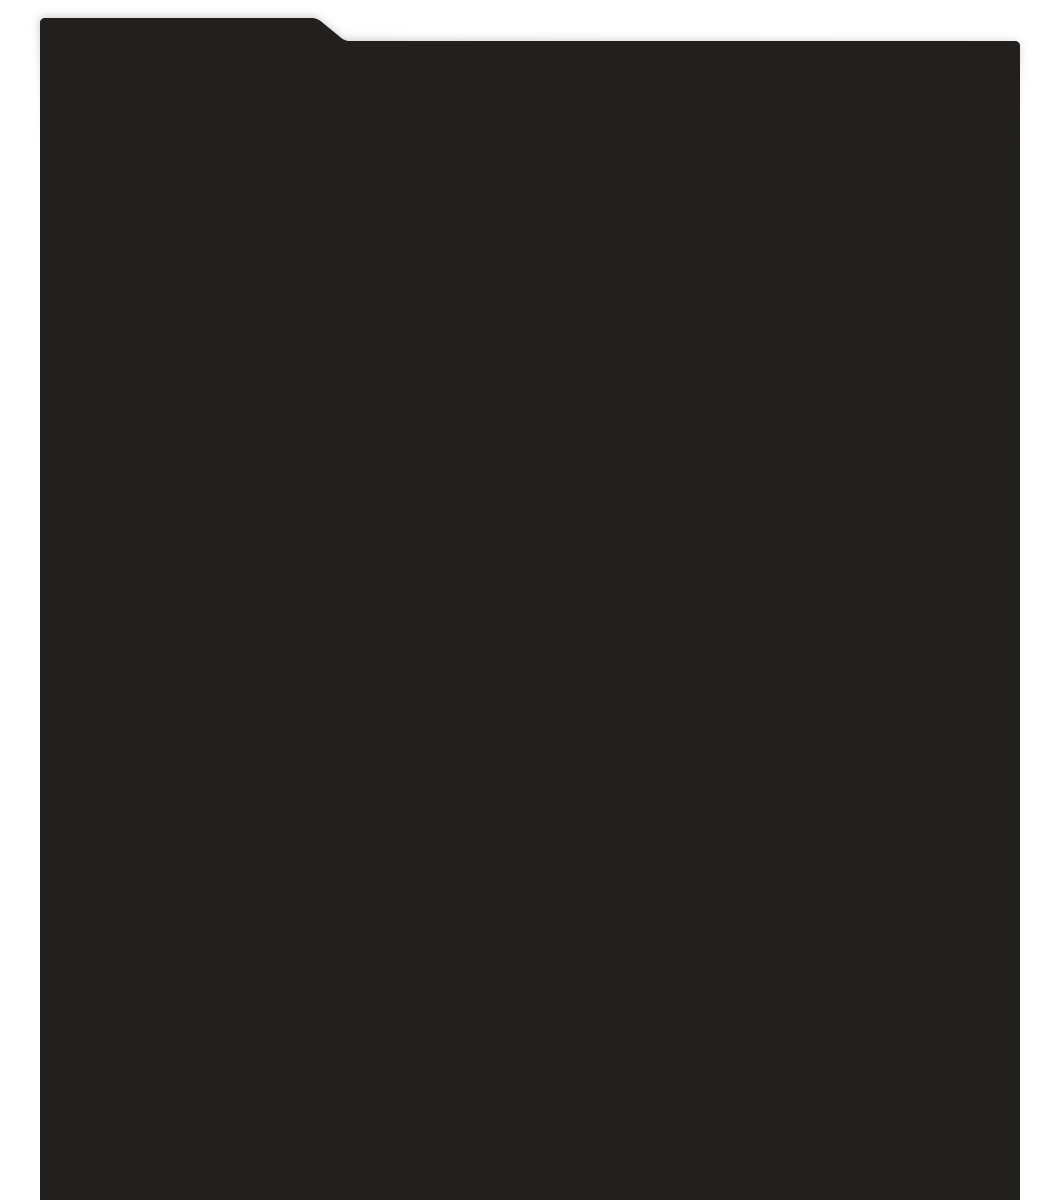
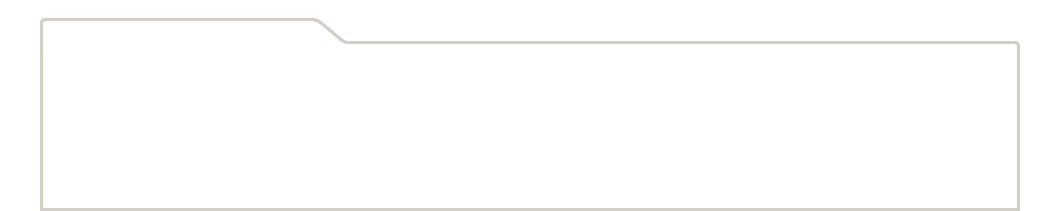
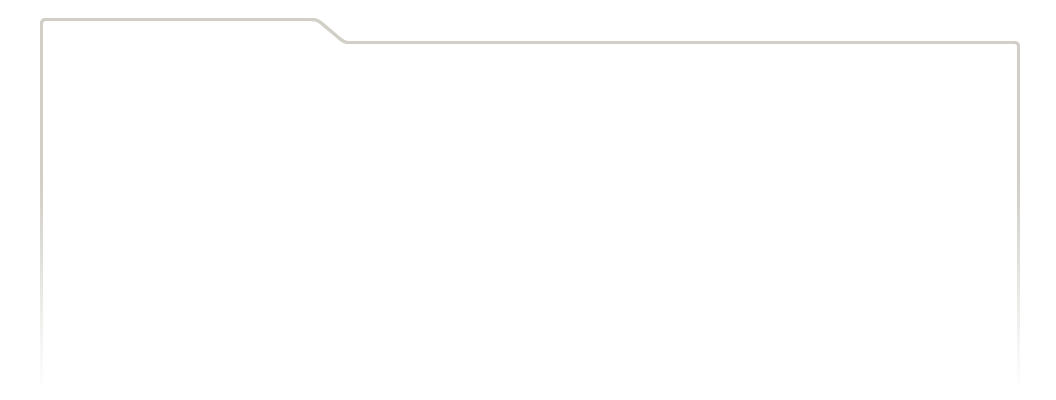
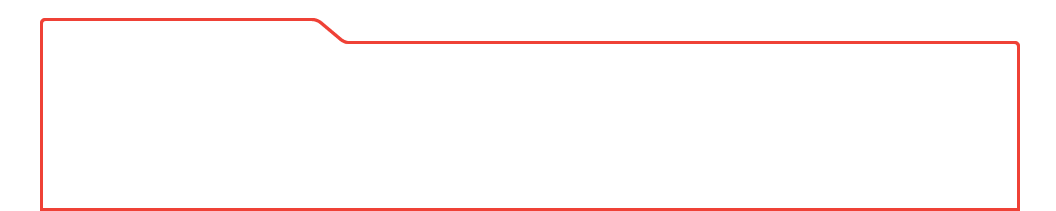
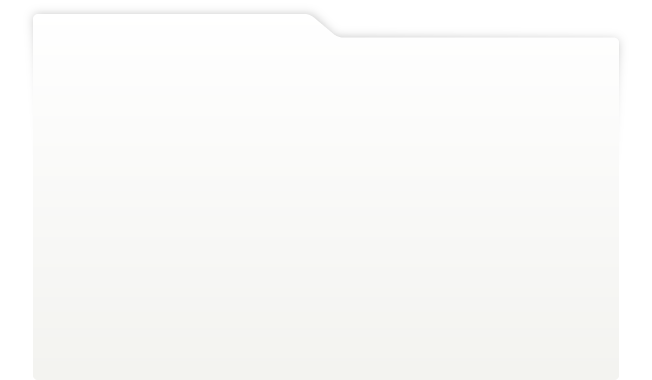
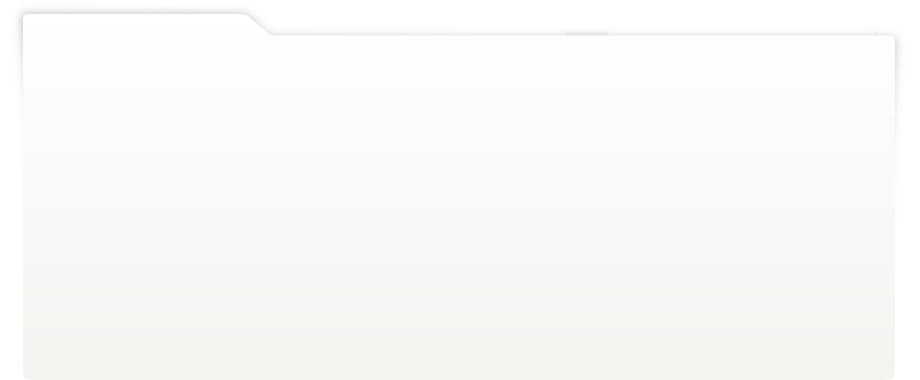
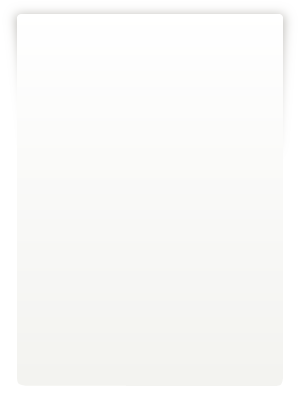
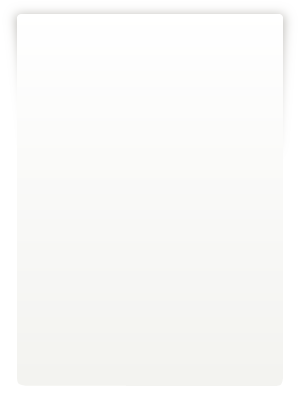
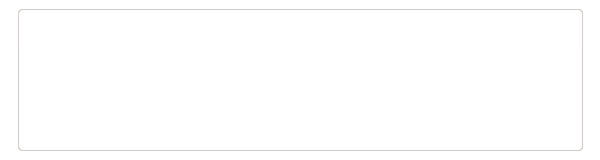
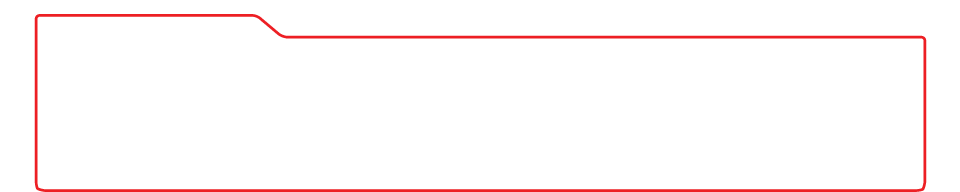
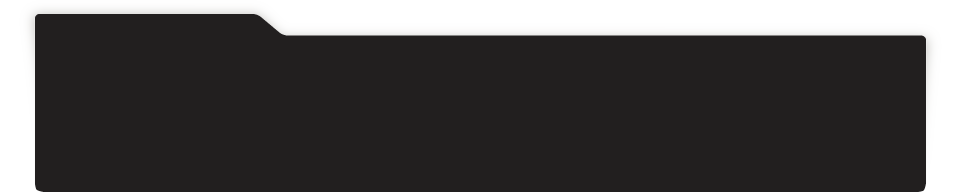
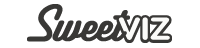
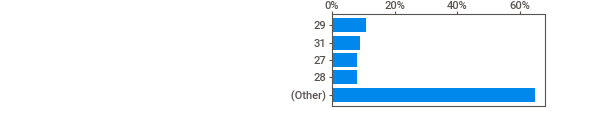
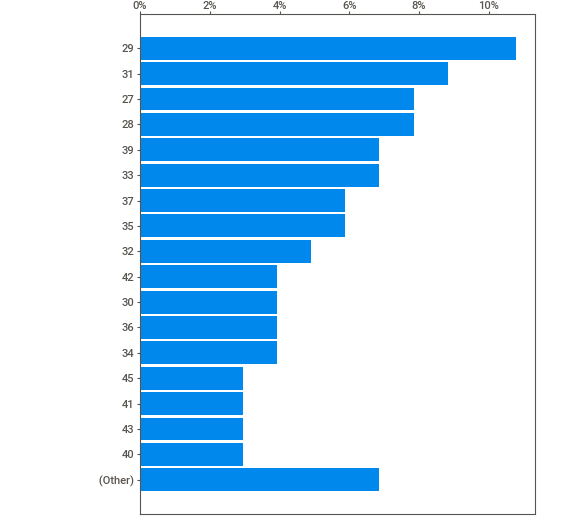
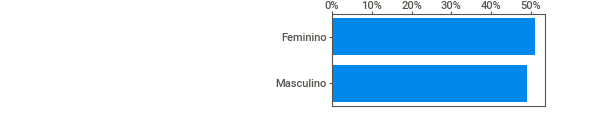
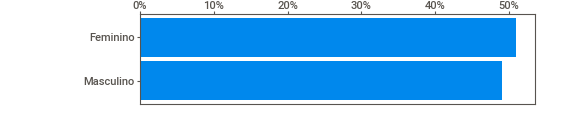
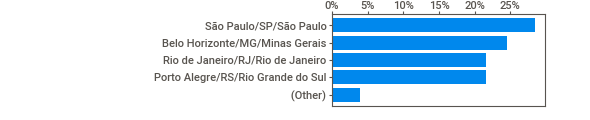
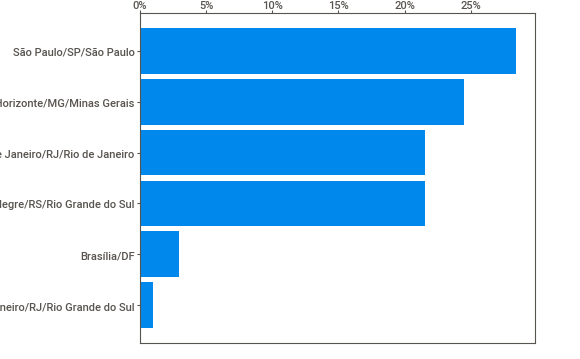
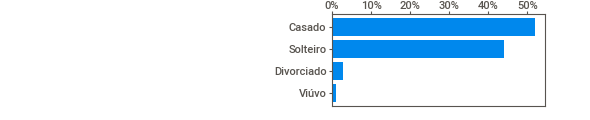
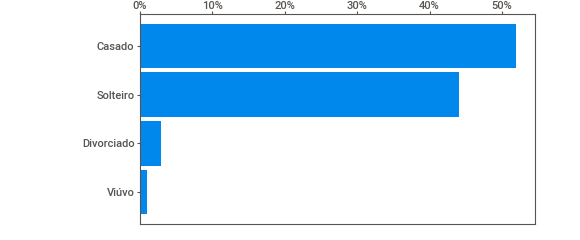
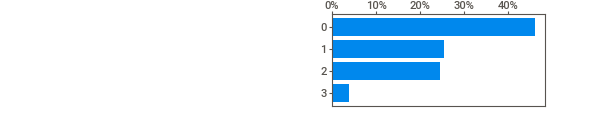
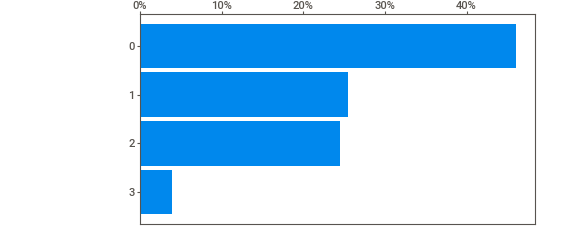
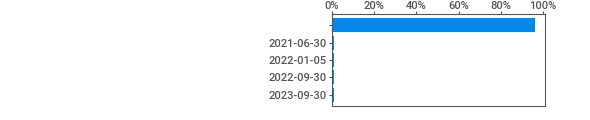
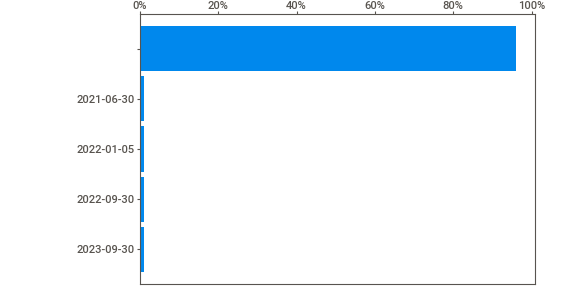
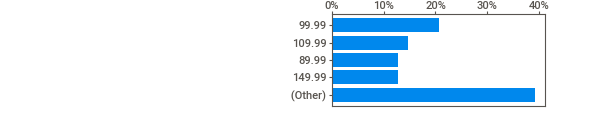
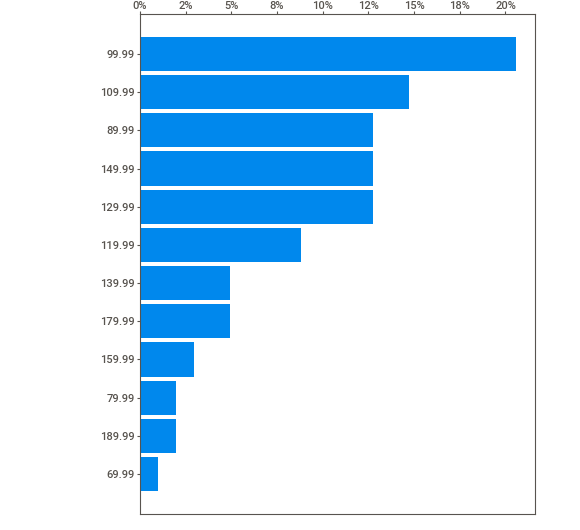
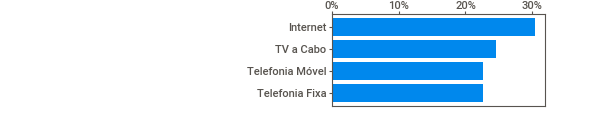
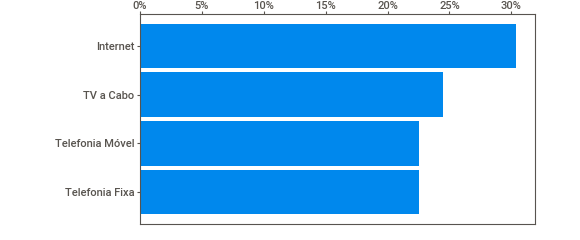
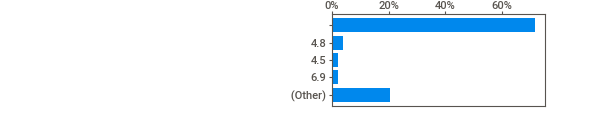
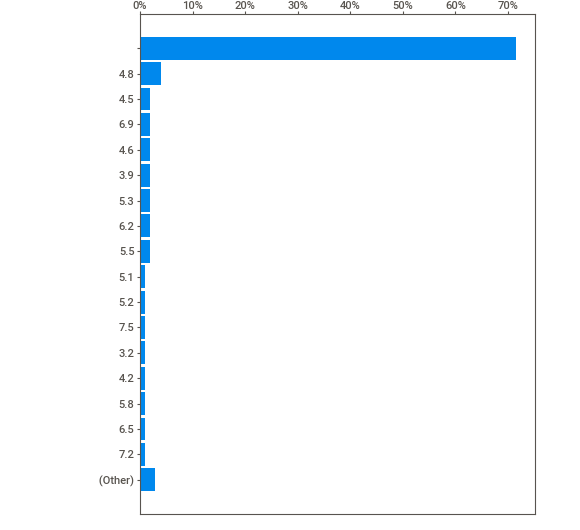
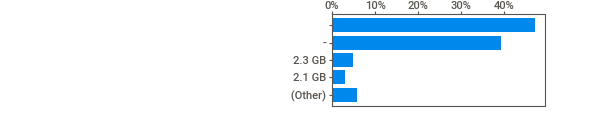
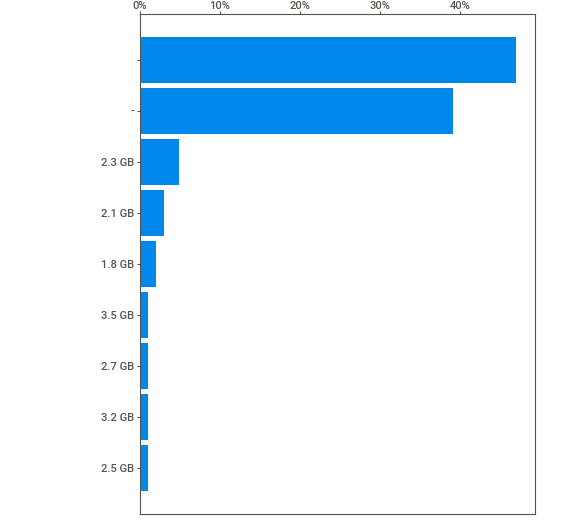
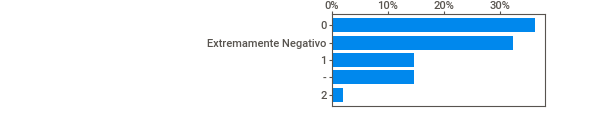
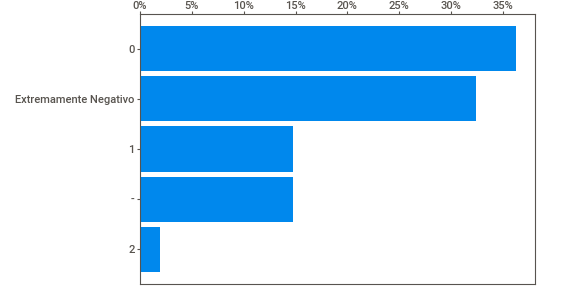

In [12]:
report = sv.analyze(dataChurn, pairwise_analysis='off')
report.show_notebook()

2.1: Preenchendo os vazios com NA

In [13]:
dataChurn = dataChurn.replace('-', '')
dataChurn = dataChurn.replace('', pd.NA)

2.2: Conferindo tipos e valores de variáveis

In [14]:
print(dataChurn['Idade'].value_counts())
dataChurn['Idade'] = dataChurn['Idade'].astype(int)

Idade
29    11
31     9
27     8
28     8
39     7
33     7
37     6
35     6
32     5
42     4
30     4
36     4
34     4
45     3
41     3
43     3
40     3
38     2
26     2
46     1
55     1
48     1
Name: count, dtype: int64


In [15]:
dataChurn['Idade'].describe()

count    102.000000
mean      34.176471
std        5.829953
min       26.000000
25%       29.000000
50%       33.000000
75%       38.750000
max       55.000000
Name: Idade, dtype: float64

In [16]:
dataChurn['Localização'].value_counts()

Localização
São Paulo/SP/São Paulo                 29
Belo Horizonte/MG/Minas Gerais         25
Rio de Janeiro/RJ/Rio de Janeiro       22
Porto Alegre/RS/Rio Grande do Sul      22
Brasília/DF                             3
Rio de Janeiro/RJ/Rio Grande do Sul     1
Name: count, dtype: int64

In [17]:
dataChurn['Estado Civil'].value_counts()

Estado Civil
Casado        53
Solteiro      45
Divorciado     3
Viúvo          1
Name: count, dtype: int64

In [18]:
print(dataChurn['Número de Dependentes'].value_counts())
dataChurn['Número de Dependentes'] = dataChurn['Número de Dependentes'].astype(
    int)

Número de Dependentes
0    47
1    26
2    25
3     4
Name: count, dtype: int64


In [19]:
dataChurn['Data de Início do Contrato'] = pd.to_datetime(
    dataChurn['Data de Início do Contrato'])
dataChurn['Data de Término do Contrato'] = pd.to_datetime(
    dataChurn['Data de Término do Contrato'])

In [20]:
dataChurn['Volume de Dados'].value_counts()

Volume de Dados
2.3 GB    5
2.1 GB    3
1.8 GB    2
3.5 GB    1
2.7 GB    1
3.2 GB    1
2.5 GB    1
Name: count, dtype: int64

In [21]:
dataChurn['Duração Média das Chamadas'].value_counts()

Duração Média das Chamadas
4.8    4
4.5    2
3.9    2
6.9    2
6.2    2
4.6    2
5.3    2
5.5    2
5.2    1
5.1    1
7.5    1
3.2    1
4.2    1
5.8    1
6.5    1
7.2    1
5.9    1
4.3    1
6.7    1
Name: count, dtype: int64

In [22]:
dataChurn['Valor Mensal do Contrato'] = dataChurn['Valor Mensal do Contrato'].astype(
    float)

## 3. Analisando os dados

3.1: EDA Automatizada para verificar o geral dos dados

Feature: ID                                  |▋         | [  6%]   00:00 -> (00:00 left)c:\Users\jpfas\Downloads\CaseA3\.venv\lib\site-packages\sweetviz\from_profiling_pandas.py:65: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(keys):
Feature: Nome                                |█▎        | [ 12%]   00:00 -> (00:00 left)c:\Users\jpfas\Downloads\CaseA3\.venv\lib\site-packages\sweetviz\from_profiling_pandas.py:65: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(keys):
Feature: Gênero                              |██▌       | [ 25%]   00:00 -> (00:01 left)c:\Users\jpfas\Downloads\CaseA3\.venv\lib\site-packages\sweetviz\from_profiling_pandas.py:65: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future ve


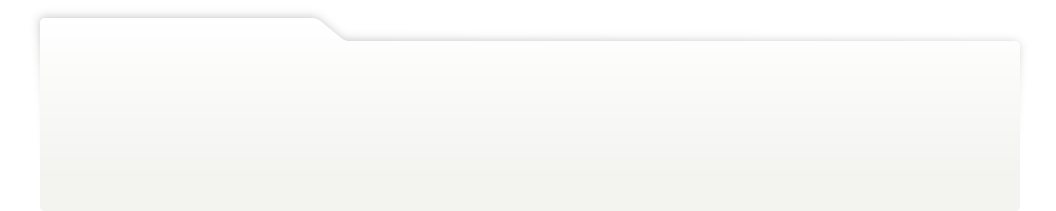
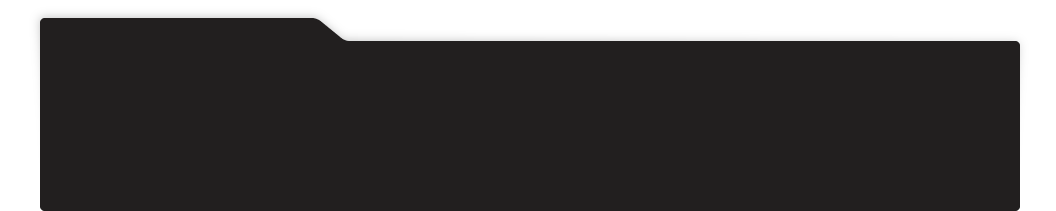
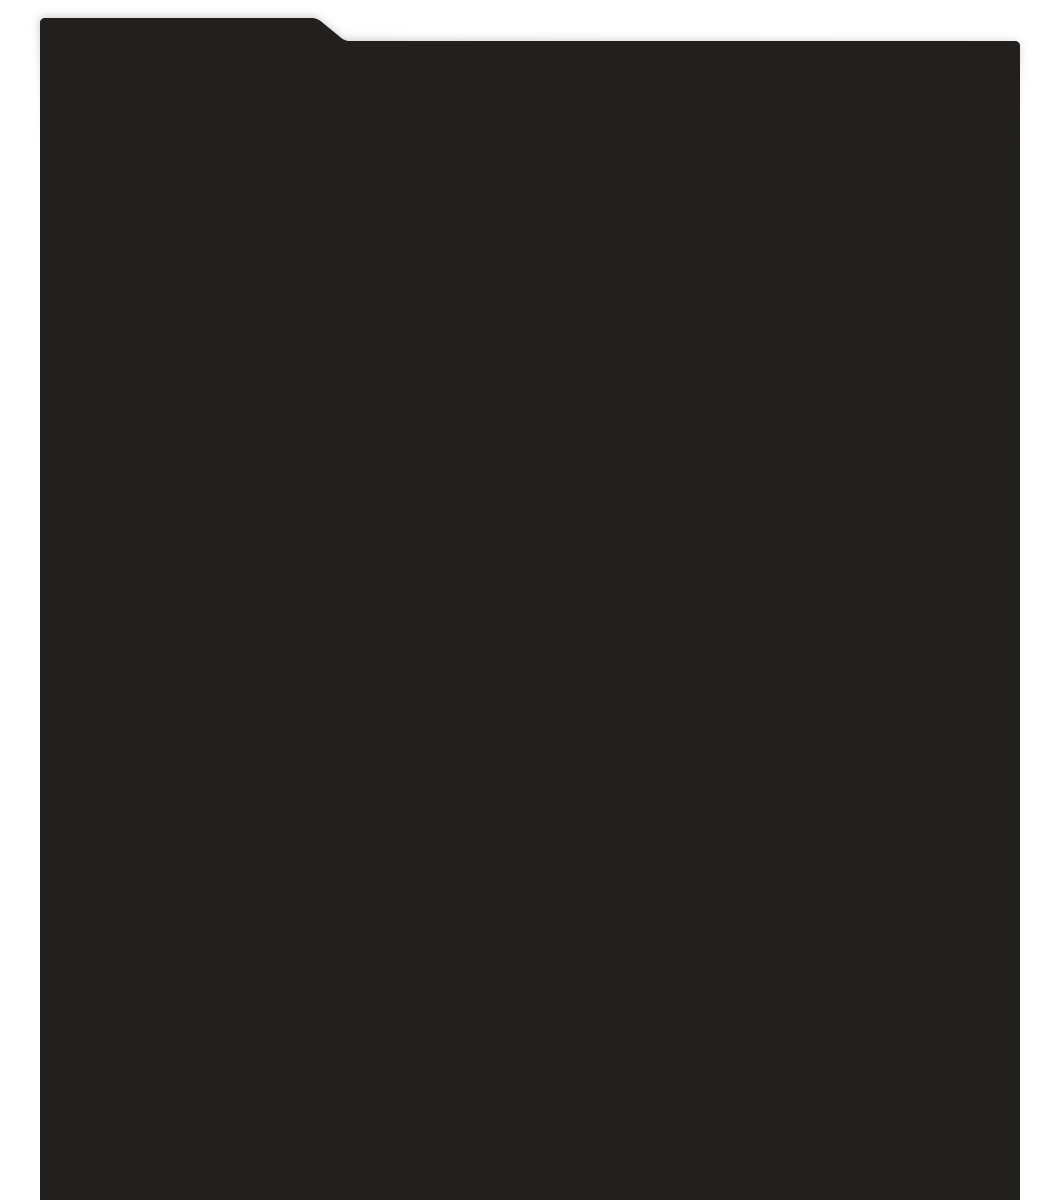
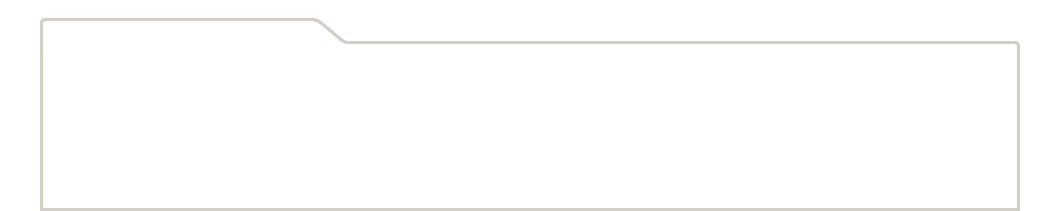
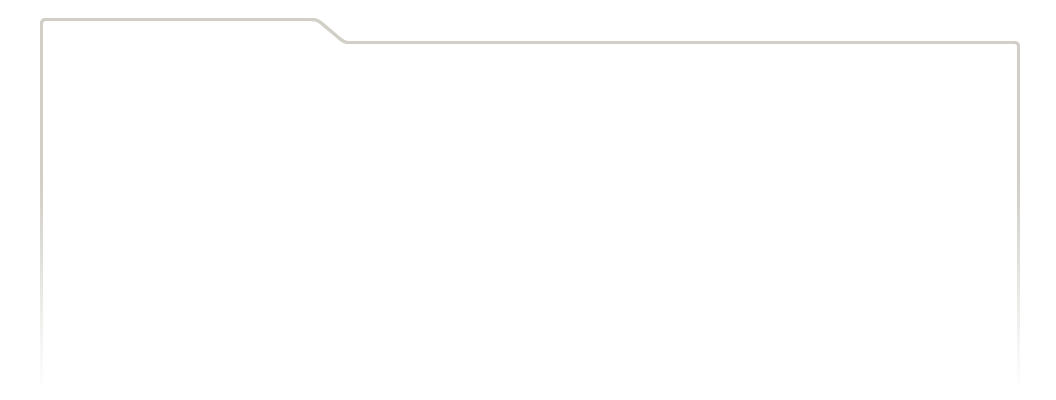
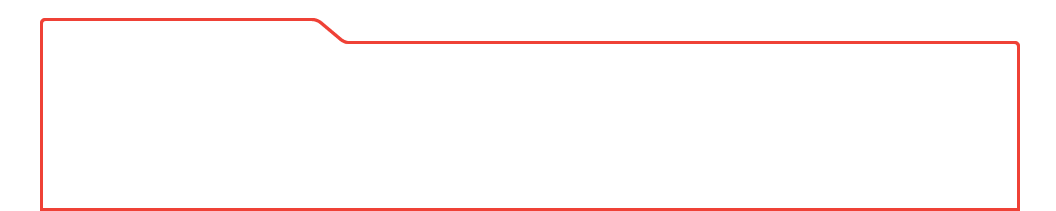
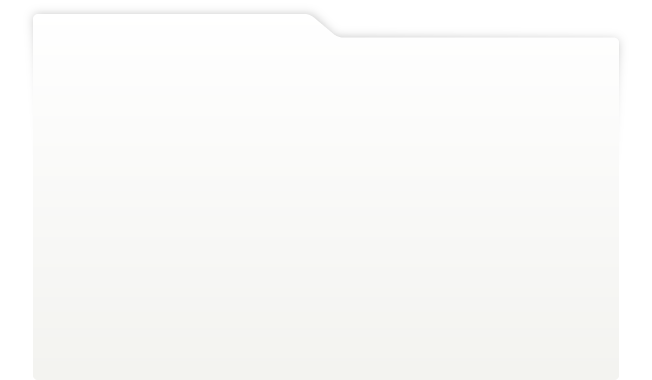
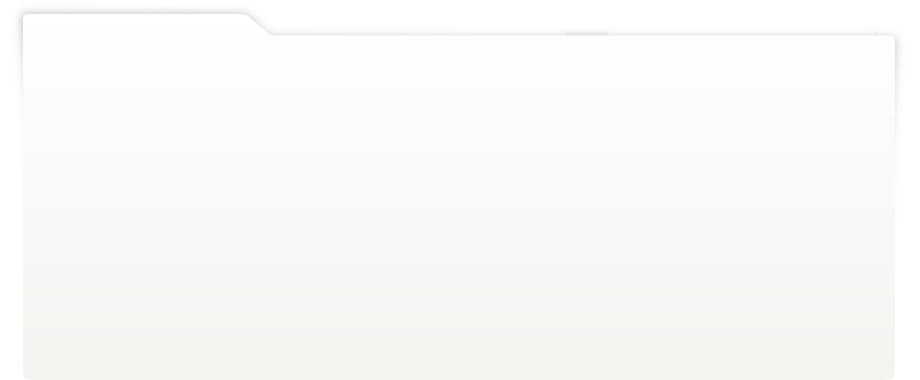
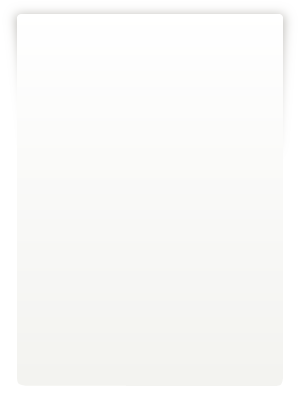
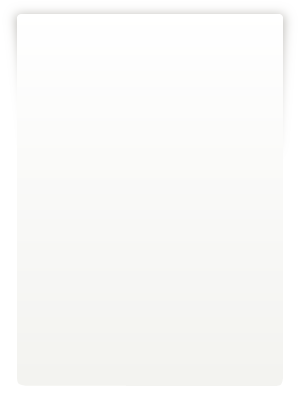
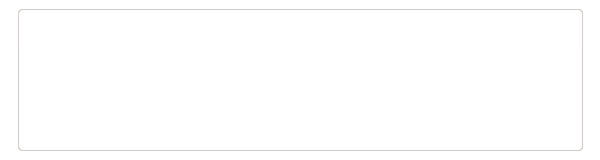
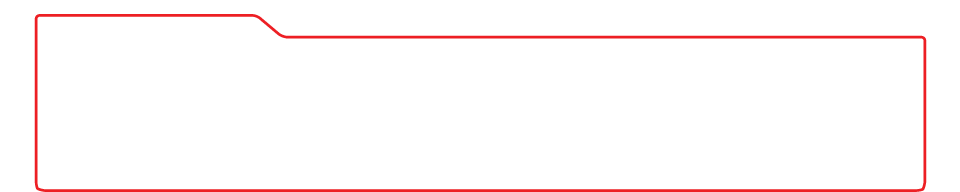
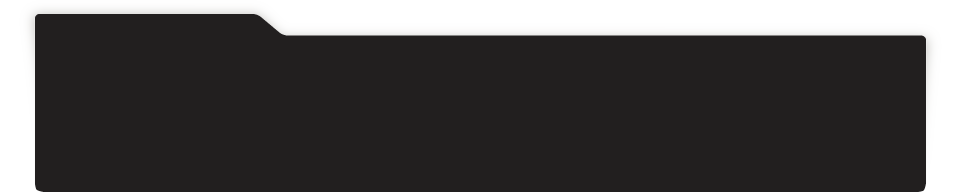
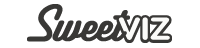
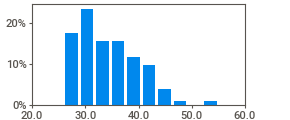
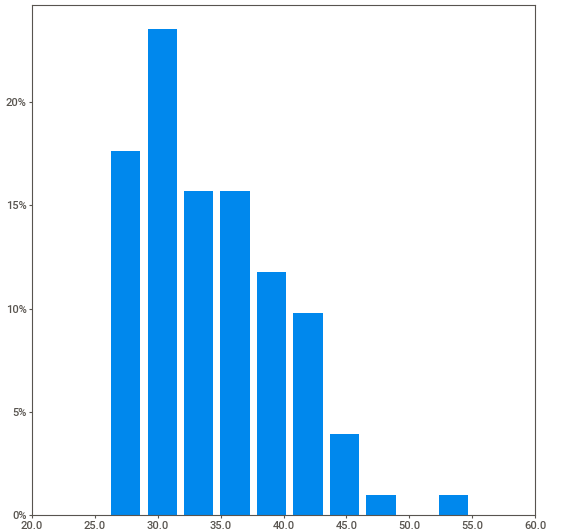
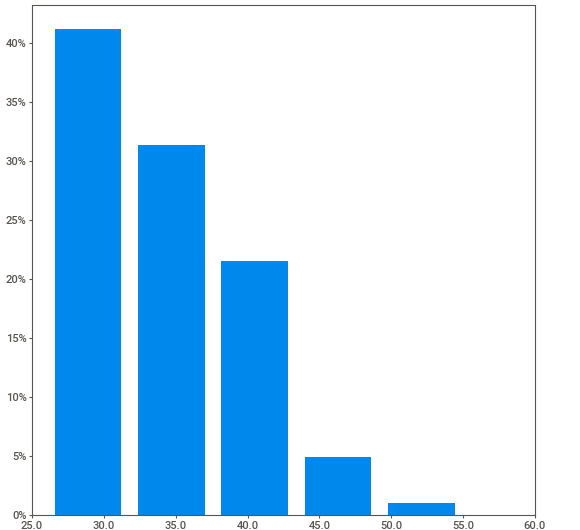
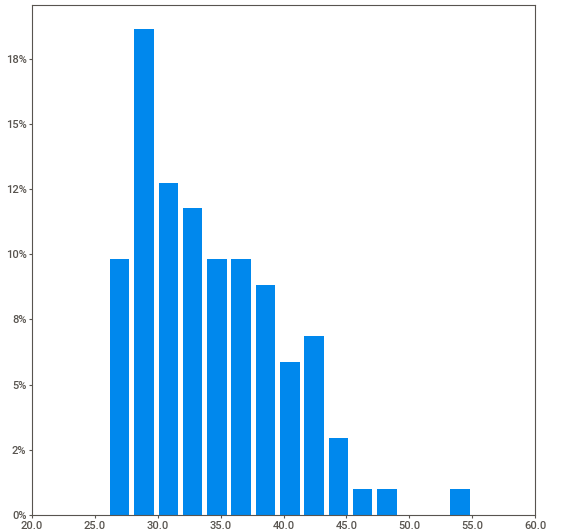
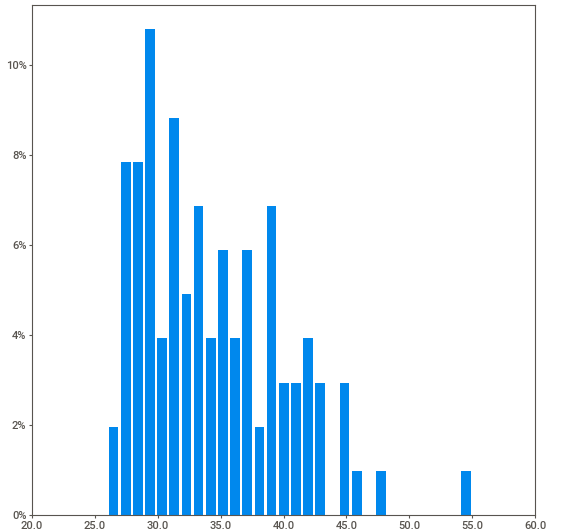
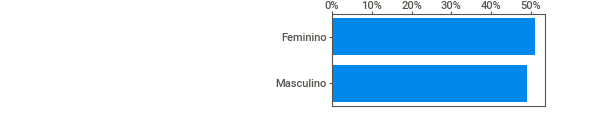
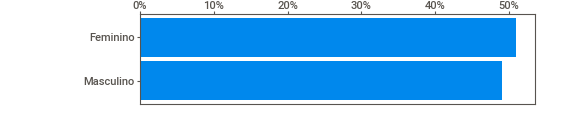
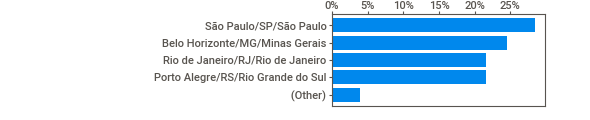
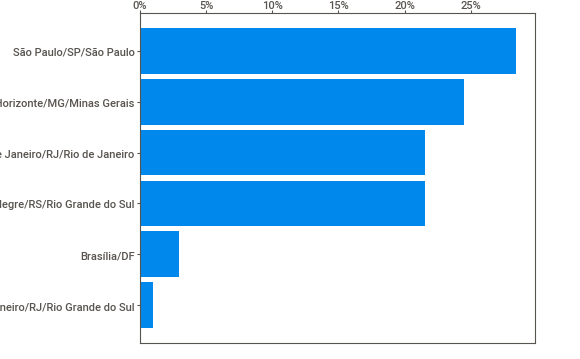
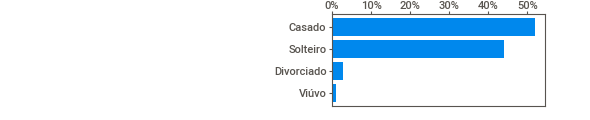
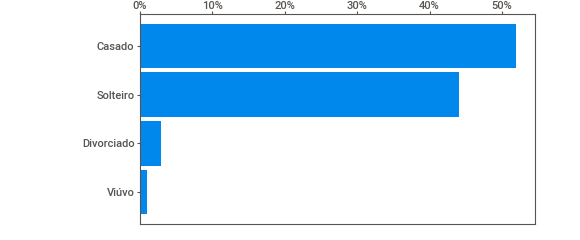
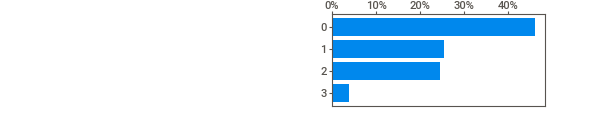
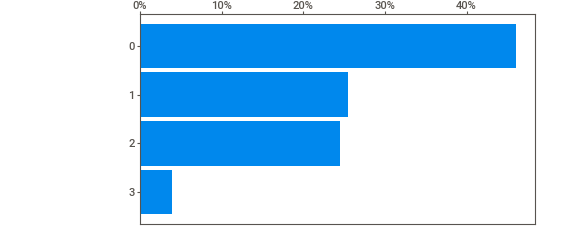
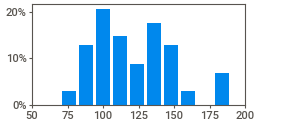
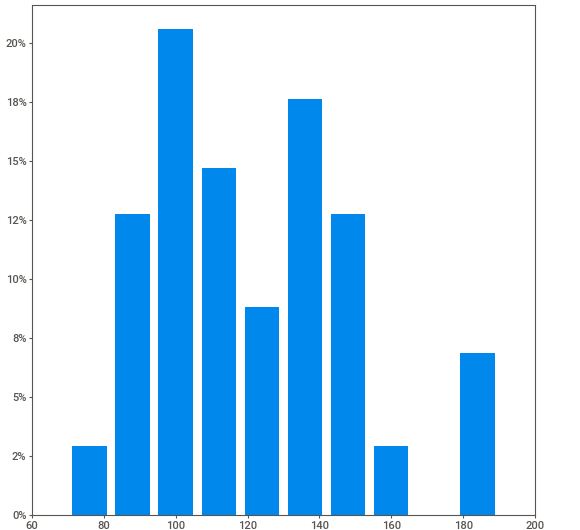
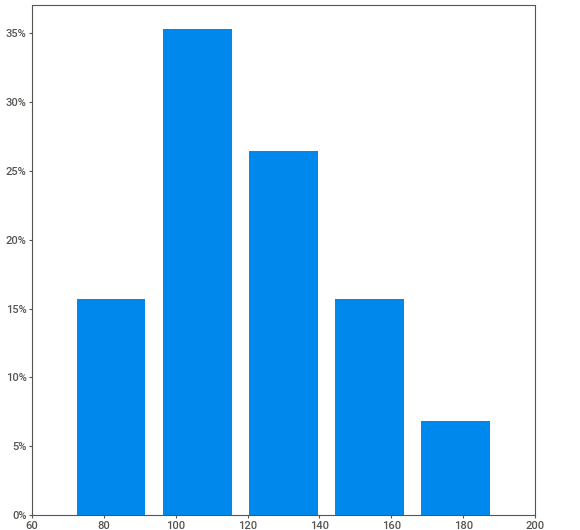
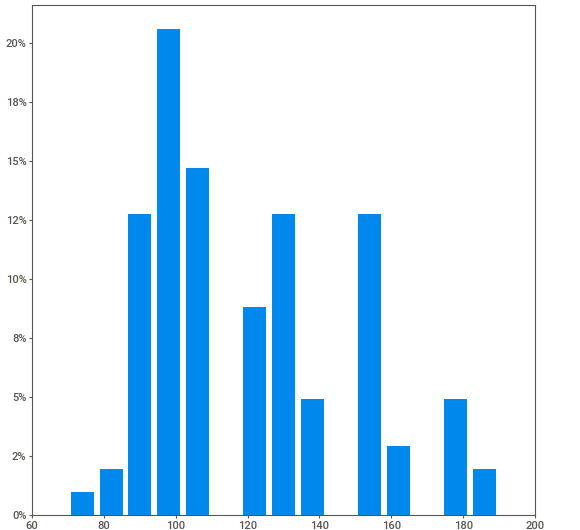
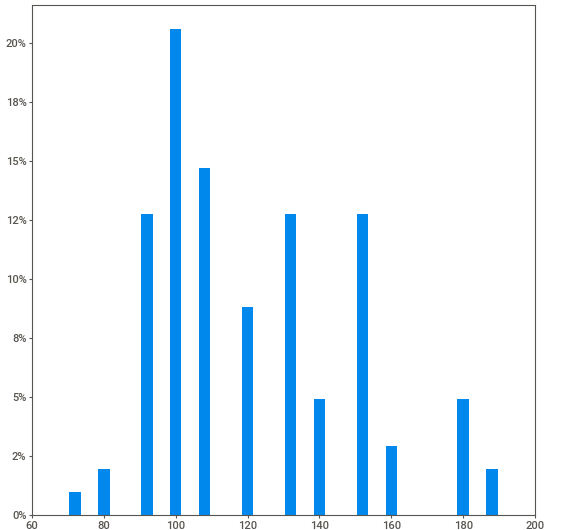
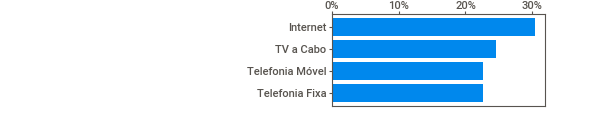
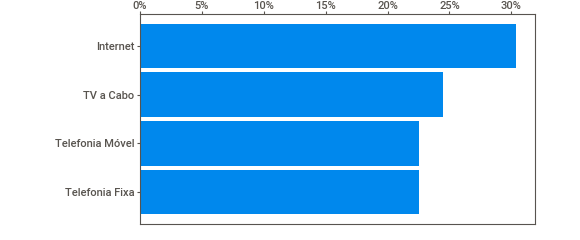
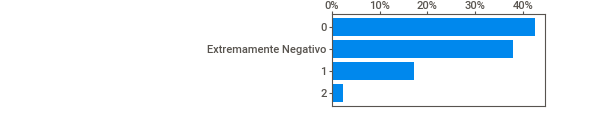
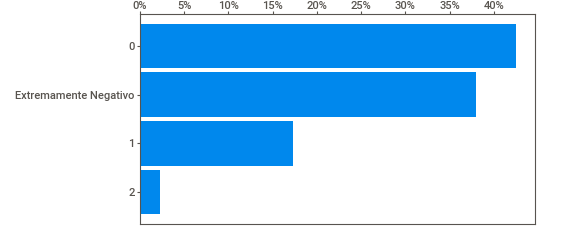

In [23]:
report = sv.analyze(dataChurn, pairwise_analysis='off')
report.show_notebook()

In [24]:
# Mesmo nome mas aparentemente pessoas diferentes
dataChurn[dataChurn.Nome == 'Carolina Oliveira']

,ID,Nome,Idade,Gênero,Localização,Estado Civil,Número de Dependentes,Data de Início do Contrato,Data de Término do Contrato,Valor Mensal do Contrato,Tipo de Serviço,Duração Média das Chamadas,Volume de Dados,Número de Reclamações,Comentários
27,1023,Carolina Oliveira,32,Feminino,Porto Alegre/RS/Rio Grande do Sul,Solteiro,0,2021-04-12,NaT,109.99,Telefonia Móvel,4.2,2.1 GB,0,Estou satisfeita com o serviço de telefonia mó...
48,1044,Carolina Oliveira,31,Feminino,Porto Alegre/RS/Rio Grande do Sul,Solteiro,0,2022-03-20,NaT,89.99,Internet,<NA>,<NA>,0,Estou bastante satisfeita com o serviço de int...
71,1069,Carolina Oliveira,35,Feminino,Belo Horizonte/MG/Minas Gerais,Casado,2,2019-04-05,NaT,119.99,TV a Cabo,<NA>,<NA>,Extremamente Negativo,Não consigo expressar o quão decepcionada esto...


3.2: Limpeza dos comentários e classificação do sentimento

In [25]:
dataChurn['Comentários'] = dataChurn['Comentários'].apply(
    lambda x: re.sub('[^\w\s]', '', x))
dataChurn['Comentários'] = dataChurn['Comentários'].apply(
    lambda x: re.sub('\s+', ' ', x))

In [26]:
analyser = SentimentIntensityAnalyzer()
dataChurn['Sentimento Comentário'] = dataChurn['Comentários'].apply(
    lambda x: analyser.polarity_scores(x)['compound'])
dataChurn['Sentimento Comentário'] = ["Negativo" if value < -0.1 else "Positivo" if value >
                                      0.1 else "Neutro" for value in dataChurn['Sentimento Comentário']]
dataChurn['Sentimento Comentário'].value_counts()

Sentimento Comentário
Negativo    53
Positivo    42
Neutro       7
Name: count, dtype: int64

In [27]:
dataChurn.groupby('Localização')['Sentimento Comentário'].value_counts()

Localização                          Sentimento Comentário
Belo Horizonte/MG/Minas Gerais       Negativo                 12
                                     Positivo                 11
                                     Neutro                    2
Brasília/DF                          Negativo                  2
                                     Positivo                  1
Porto Alegre/RS/Rio Grande do Sul    Negativo                 15
                                     Positivo                  6
                                     Neutro                    1
Rio de Janeiro/RJ/Rio Grande do Sul  Positivo                  1
Rio de Janeiro/RJ/Rio de Janeiro     Negativo                 12
                                     Positivo                  9
                                     Neutro                    1
São Paulo/SP/São Paulo               Positivo                 14
                                     Negativo                 12
                               

In [28]:
# Tempo de contrato médio
(datetime.now() - dataChurn['Data de Início do Contrato']).mean()

Timedelta('1131 days 14:26:11.758783664')

In [29]:
churnClients = dataChurn[~dataChurn['Data de Término do Contrato'].isna()]
churnClients['Duração do Contrato'] = (
    churnClients['Data de Término do Contrato'] - churnClients['Data de Início do Contrato'])

C:\Users\jpfas\AppData\Local\Temp\ipykernel_14660\3263359715.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  churnClients['Duração do Contrato'] = (


3.3: Intervalo médio entre saída e entrada de clientes.

In [30]:
churnDates = churnClients.sort_values('Data de Término do Contrato')[
    'Data de Término do Contrato'].values
churnInterval = []
for i in range(len(churnDates)-1):
    churnInterval.append(
        (churnDates[i+1] - churnDates[i]).item()/(3600*24*1e9))
np.mean(churnInterval)

274.0

In [31]:
nonChurnDates = dataChurn[dataChurn['Data de Término do Contrato'].isna()].sort_values(
    'Data de Início do Contrato')['Data de Início do Contrato'].values
acquisitionInterval = []
for i in range(len(nonChurnDates)-1):
    acquisitionInterval.append(
        (nonChurnDates[i+1] - nonChurnDates[i]).item()/(3600*24*1e9))
np.mean(acquisitionInterval)

20.54639175257732

3.4: Ngramas e nuvens de palavras.

In [32]:
def ngrams_wordcloud(comments, n):
    comments = ' '.join(comments.values).lower()
    comments = [word for word in comments.split(
        ' ') if not word in stopwords.words('portuguese')]
    ngramsComments = list(ngrams(comments, n))
    print(collections.Counter(ngramsComments).most_common(5))
    plt.figure(figsize=(5, 4), facecolor=None)
    plt.imshow(WordCloud(width=500, height=400).generate(' '.join(comments)))
    plt.axis("off")
    plt.tight_layout(pad=0)

    plt.show()

[(('qualidade', 'imagem'), 2), (('problemas', 'fatura'), 1), (('fatura', 'deste'), 1), (('deste', 'mês'), 1), (('mês', 'valor'), 1)]


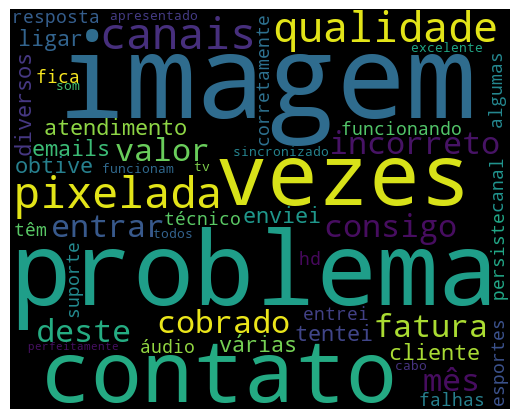

In [33]:
ngrams_wordcloud(churnClients['Comentários'], 2)

[(('serviço', 'telefonia'), 34), (('dessa', 'empresa'), 25), (('suporte', 'técnico'), 24), (('satisfeita', 'serviço'), 23), (('nunca', 'problemas'), 23)]


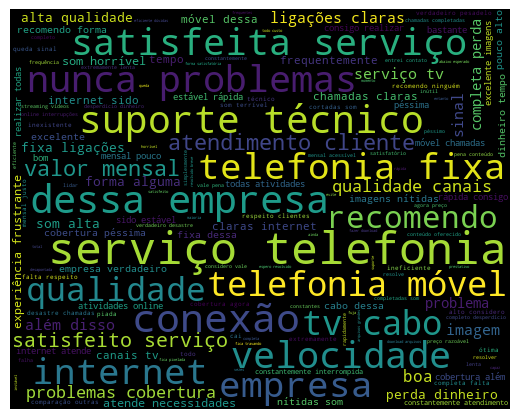

In [34]:
ngrams_wordcloud(dataChurn['Comentários'], 2)

[(('serviço', 'telefonia'), 17), (('valor', 'mensal'), 17), (('satisfeita', 'serviço'), 15), (('satisfeito', 'serviço'), 14), (('nunca', 'problemas'), 13)]


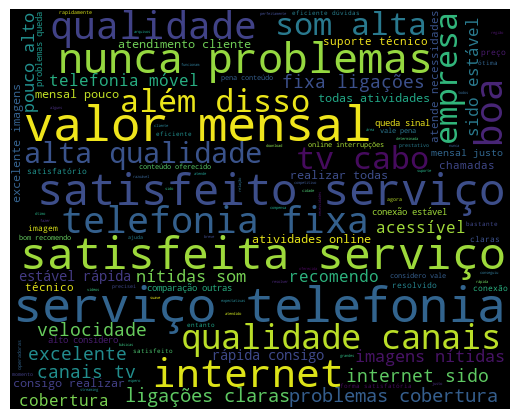

In [35]:
ngrams_wordcloud(
    dataChurn[dataChurn['Sentimento Comentário'] == 'Positivo']['Comentários'], 2)

[(('dessa', 'empresa'), 24), (('suporte', 'técnico'), 18), (('serviço', 'telefonia'), 15), (('telefonia', 'móvel'), 13), (('completa', 'perda'), 11)]


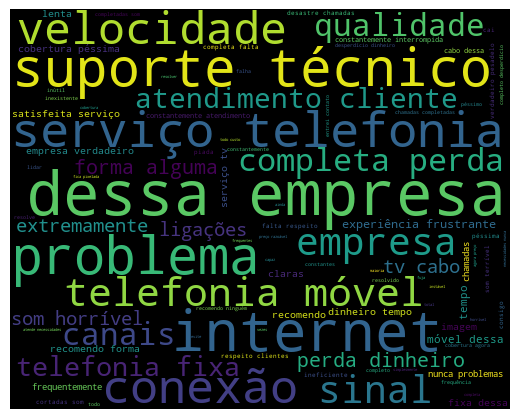

In [36]:
ngrams_wordcloud(
    dataChurn[dataChurn['Sentimento Comentário'] == 'Negativo']['Comentários'], 2)

## 4. Extração de tópicos

In [37]:
tokensTopics = [word for word in [phrase.lower().split(
    ' ') for phrase in dataChurn['Comentários']] if not word in stopwords.words('portuguese')]

In [38]:
dictionary_LDA = corpora.Dictionary(tokensTopics)
dictionary_LDA.filter_extremes(no_below=3)
corpus = [dictionary_LDA.doc2bow(list_of_tokens)
          for list_of_tokens in tokensTopics]

num_topics = 10
lda_model = models.LdaModel(corpus, num_topics=num_topics,
                            id2word=dictionary_LDA,
                            passes=4, alpha=[0.05]*num_topics,
                            eta=[0.04]*len(dictionary_LDA.keys()))

In [39]:
for i, topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=15):
    print(str(i)+": " + topic)
    print()

0: 0.081*"imagem" + 0.073*"canais" + 0.060*"os" + 0.059*"tv" + 0.053*"não" + 0.044*"sinal" + 0.043*"cabo" + 0.030*"qualidade" + 0.025*"da" + 0.023*"som" + 0.022*"pixelada" + 0.017*"um" + 0.017*"desperdício" + 0.017*"dinheiro" + 0.017*"completo"

1: 0.052*"em" + 0.040*"está" + 0.037*"problemas" + 0.036*"conexão" + 0.034*"mas" + 0.033*"contato" + 0.032*"problema" + 0.031*"da" + 0.031*"que" + 0.030*"já" + 0.029*"internet" + 0.029*"não" + 0.028*"para" + 0.028*"suporte" + 0.027*"velocidade"

2: 0.069*"qualidade" + 0.037*"excelente" + 0.035*"muito" + 0.034*"satisfeita" + 0.032*"problemas" + 0.031*"valor" + 0.031*"mensal" + 0.030*"tive" + 0.029*"alta" + 0.029*"som" + 0.029*"nunca" + 0.027*"canais" + 0.025*"dos" + 0.025*"tv" + 0.025*"cabo"

3: 0.045*"qualidade" + 0.042*"tive" + 0.040*"problemas" + 0.034*"mas" + 0.030*"nunca" + 0.024*"pouco" + 0.024*"alto" + 0.023*"internet" + 0.022*"um" + 0.021*"tv" + 0.021*"muito" + 0.019*"canais" + 0.019*"que" + 0.019*"dos" + 0.017*"técnicos"

4: 0.053*"não"

Tópicos:  
- Problemas na qualidade dos serviços (Internet lenta, imagem ruim).  
- Satisfação com o serviço.  
- Reclamações sobre o atendimento.  
- Satisfação com o custo do serviço.  

## 5. Estimativa de impacto

In [40]:
averageMonthlyValue = dataChurn['Valor Mensal do Contrato'].mean()
monthlyValue = dataChurn[dataChurn['Data de Término do Contrato'].isna(
)]['Valor Mensal do Contrato'].sum()

In [41]:
# Percentual que cada cliente representa em média da renda mensal
(averageMonthlyValue/monthlyValue)*100

1.0244270536127278

Caso as ações sugeridas consigam evitar um churn no ano e consigam também trazer um cliente antigo de volta teremos de retorno estimado:

In [42]:
2*averageMonthlyValue*12

2900.9364705882354

Ou seja, 2% do faturamento anual.

In [45]:
dataChurn.to_parquet('DataChurn.parquet')